# **configuration of saving files permenently**

**chdir to colab notebooks to save files permenently on colab**

In [ ]:
import os, sys 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks'

**clone vedai dataset from github**

In [ ]:
if not os.path.exists('vedai'):
    !git clone https://github.com/mr8bit/vedai.git

In [ ]:
# ! cp -a /content/notebooks/keras-retinanet/vedai_labels1000/. \
#     /content/notebooks/vedai_labels1000

# **import necessary libraries**

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

In [ ]:
path  = "/content/notebooks/vedai_subset1000"
annot = "/content/notebooks/vedai_labels1000"

In [ ]:
os.chdir(
   path
)
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/vedai_subset1000'

# **train R-CNN network for object detection task**

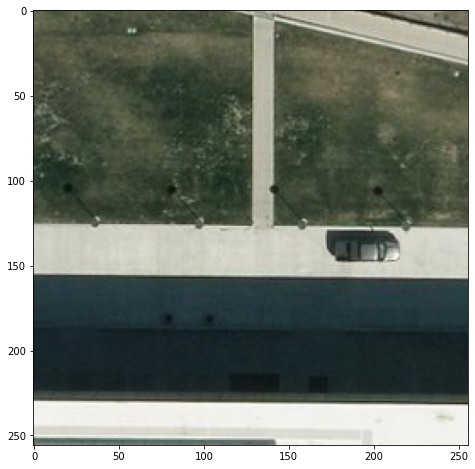

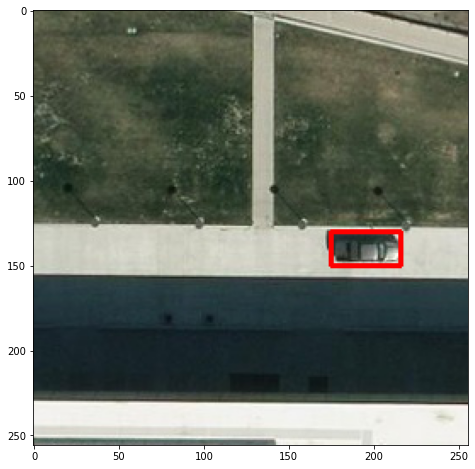

In [ ]:
Index = os.listdir(path)[0]
filename = os.path.join(path , Index)
img = np.array(Image.open(filename))
df = pd.read_csv(os.path.join(path , 'train.csv'))
df = df[df[df.columns[0]] == Index ]
plt.figure(figsize=(8 , 8))
plt.imshow(img)

for row in df.iterrows():
    x1  = row[1][1]
    y1  = row[1][2]
    x2  = row[1][3]
    y2  = row[1][4]
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure(figsize=(8 , 8))
plt.imshow(img)


In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

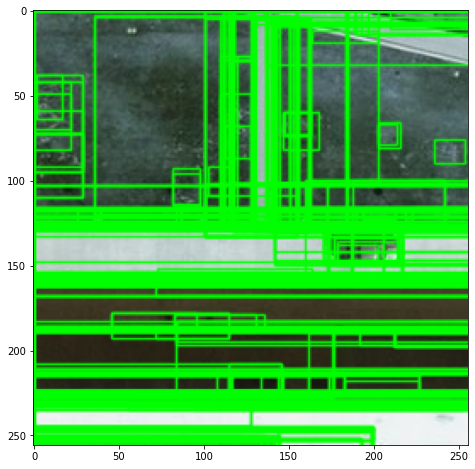

In [ ]:
im = cv2.imread(os.path.join(path,Index))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure(figsize=(8 , 8))
plt.imshow(imOut)

In [ ]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def IOU(box1, box2):
  x1 , y1 , x2 , y2 = box1
  x3 , y3 , x4 , y4 = box2
  intersect_w = _interval_overlap([x1 , x2] , [x3 , x4])
  intersect_h = _interval_overlap([y1 , y2] , [y3 , y4])
  intersect = intersect_w * intersect_h
  w1, h1 = x2 - x1 , y2 - y1
  w2, h2 = x4 - x3 , y4 -y3
  union = w1*h1 + w2*h2 - intersect
  return float(intersect) / union

In [ ]:
import time

if not os.path.exists('train_images.npy'):

    # At the end of below code we will have our train data in these lists
    train_images=[]
    train_labels=[]

    df = pd.read_csv(os.path.join(path, 'train.csv'))
    im_df = df.drop_duplicates(subset=df.columns[0])

    # df.head()

    start = time.time()

    for i, img in im_df.iterrows():

        if i < 20000:

            image = cv2.imread(os.path.join(path, img[0]))
            b_df = df[df[df.columns[0]] == img[0]]

            box_list = []

            for row in b_df.iterrows():

                x1 = row[1][1]
                y1 = row[1][2]
                x2 = row[1][3]
                y2 = row[1][4]

                box_list.append([x1, y1, x2, y2])

            ss.setBaseImage(image)  # setting given image as base image
            ss.switchToSelectiveSearchFast()  # running selective search on bae image
            ssresults = ss.process()  # processing to get the outputs
            imout = image.copy()

            counter = 0  # true sample
            falsecounter = 0  # negative sample
            flag = False  # complete
            tflag = False  # true ends
            bflag = False  # false ends

            for e, result in enumerate(ssresults):

                if e < 2000 and not flag:  # till 2000 to get top 2000 regions only

                    x, y, w, h = result

                    iou_list = [IOU(gtval, [x, y, x + w, y + h]) < 0.75 for gtval in box_list]

                    if all(iou_list):

                        if not bflag:
                            timage = imout[y:y+h , x:x+w]
                            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1

                    else:

                        if not tflag:
                            timage = imout[y:y+h , x:x+w]
                            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1

                    bflag = False if falsecounter < len(box_list) else True
                    tflag = False if counter < len(box_list) else True

                    flag = tflag and bflag

        else:
            break

    end = time.time()

    print(f'elapsed time of generating training images : {end - start}')

elapsed time of generating training images : 798.971599817276


In [ ]:
import random
if not os.path.exists('train_images.npy'):
    cars = [ i for i in range(len(train_labels)) if train_labels[i] == 1 ]
    sample_list = random.choices(cars, k=9)
    sample_list

[2291, 3741, 2467, 715, 3531, 3621, 590, 1378, 2707]

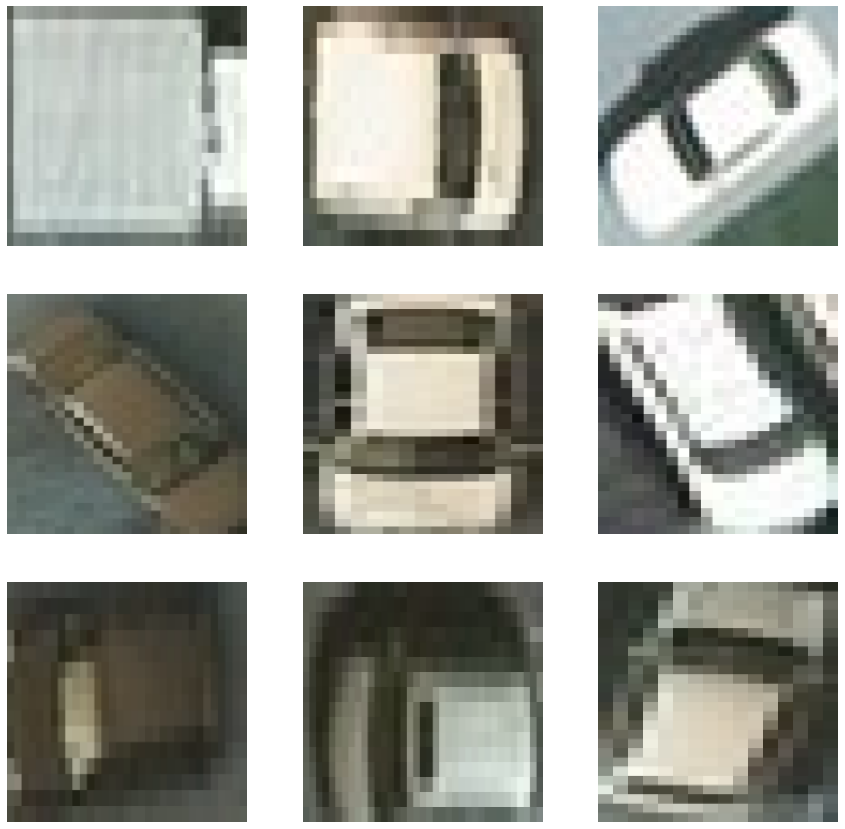

In [ ]:
if not os.path.exists('train_images.npy'):
    plt.figure(figsize=(15, 15))

    for idx , im_name in enumerate(sample_list):
        plt.subplot(330 + idx + 1)
        im = train_images[im_name]
        plt.axis('off')
        plt.imshow(im)
    plt.show()

In [ ]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/vedai_subset1000'

In [ ]:
if not os.path.exists('train_images.npy'):
    X_new = np.array(train_images)
    Y_new = np.array(train_labels)
    np.save('train_images.npy' , X_new)
    np.save('train_labels.npy' , Y_new)
else:
    X_new = np.load('train_images.npy')
    Y_new = np.load('train_labels.npy')   

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers

In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [ ]:
model.summary()
history = model.fit(X_new,Y_new,batch_size = 64,epochs = 5, verbose = 1,validation_split= 0.2,shuffle = True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

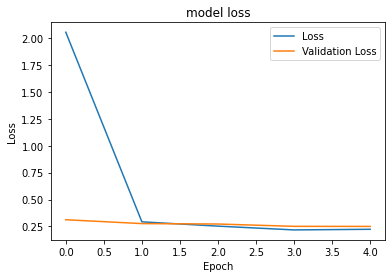

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

**evaluate model on test dataset**

In [ ]:
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [ ]:
df = pd.read_csv(os.path.join(path , 'test.csv'))
df.head()

,4209.jpg,44,123,115,187,car
0,4209.jpg,27,123,59,159,car
1,1040.jpg,70,133,92,166,car
2,794.jpg,156,205,182,219,car
3,794.jpg,154,225,184,242,car
4,794.jpg,114,228,142,246,car


**generate test dataset**

In [ ]:
pred_columns_dict = {'Name' : [] , 
                     'x1' : [] ,
                     'y1' : [] , 
                     'x2' : [] ,
                     'y2' : [] , 
                     'label'  :[]}
pred_boxes = pd.DataFrame(pred_columns_dict)
pred_boxes.head()

,Name,x1,y1,x2,y2,label


In [ ]:
import time

# At the end of below code we will have our train data in these lists
test_images=[]
test_labels=[]

df = pd.read_csv(os.path.join(path, 'test.csv'))
im_df = df.drop_duplicates(subset=df.columns[0])

# df.head()

start = time.time()

for i, img in im_df.iterrows():

    if i < 20000:

        image = cv2.imread(os.path.join(path, img[0]))
        b_df = df[df[df.columns[0]] == img[0]]

        box_list = []

        for row in b_df.iterrows():

            x1 = row[1][1]
            y1 = row[1][2]
            x2 = row[1][3]
            y2 = row[1][4]

            box_list.append([x1, y1, x2, y2])

        ss.setBaseImage(image)  # setting given image as base image
        ss.switchToSelectiveSearchFast()  # running selective search on bae image
        ssresults = ss.process()  # processing to get the outputs
        imout = image.copy()

        counter = 0  # true sample
        falsecounter = 0  # negative sample
        flag = False  # complete
        tflag = False  # true ends
        bflag = False  # false ends

        for bb in box_list:
            timage = imout[bb[1]:bb[3] , bb[0]:bb[2]]
            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
            test_images.append(resized)
            test_labels.append(1)
            counter += 1

        for e, result in enumerate(ssresults):

            if e < 2000 and not flag:  # till 2000 to get top 2000 regions only

                x, y, w, h = result

                iou_list = [IOU(gtval, [x, y, x + w, y + h]) < 0.75 for gtval in box_list]

                if all(iou_list):

                    if not bflag:
                        timage = imout[y:y+h , x:x+w]
                        resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                        test_images.append(resized)
                        test_labels.append(0)
                        falsecounter += 1

                bflag = False if falsecounter < len(box_list) else True
                tflag = False if counter < len(box_list) else True

                flag = tflag and bflag

    else:
        break

end = time.time()

print(f'elapsed time of generating training images : {end - start}')

elapsed time of generating training images : 226.38634991645813


In [ ]:
if not os.path.exists('test_images.npy'):
    tnpy  = np.array(test_images)
    tlnpy = np.array(test_labels)
    np.save('test_images.npy' , tnpy)
    np.save('test_labels.npy' , tlnpy)
else:
    tnpy  = np.load('test_images.npy')
    tlnpy = np.load('test_labels.npy') 

In [ ]:
model.evaluate(tnpy , tlnpy)

49/49 [==============================] - 13s 203ms/step - loss: 0.4655 - acc: 0.8458


[0.46548253297805786, 0.8457583785057068]

# **let's evaluate model on another dataset**

In [ ]:
if not os.path.exists('aerial-cars-dataset'):
    !git clone https://github.com/jekhor/aerial-cars-dataset.git

In [ ]:
test_dirs = []
prefix = 'aerial/'
with open('aerial-cars-dataset/test2.txt' , 'r') as f:
     for line in f:
         if line.startswith(prefix):
             test_dirs.append(line[len(prefix) : -1 ])
test_dirs

['DJI_0005-0147.jpg',
 'DJI_0005-0019.jpg',
 'DJI_0005-0175.jpg',
 'DJI_0005-0203.jpg',
 'DJI_0022.JPG',
 'DJI_0020.JPG',
 'DJI_0005-0165.jpg',
 'DJI_0005-0176.jpg',
 'harlem-0210.jpg',
 'DJI_0021.JPG',
 'DJI_0005-0078.jpg',
 'DJI_0005-0070.jpg',
 'DJI_0005-0124.jpg',
 'DJI_0014.JPG',
 'harlem-0053.jpg']

In [ ]:
os.chdir('aerial-cars-dataset')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/vedai_subset1000/aerial-cars-dataset'

In [ ]:
def yolobb2vocbb(box , size):
    #box : [X , Y , W , H]
    #size :[width , height]
    box = [float(b) for b in box]
    center_x  = box[0] * size[0]
    center_y  = box[1] * size[1]

    x1  = center_x - (box[2] * size[0] / 2 )
    x2  = center_x + (box[2] * size[0] / 2 )

    y1  = center_y - (box[3] * size[1] / 2) 
    y2  = center_y + (box[3] * size[1] / 2)

    return int(x1) , int(y1) , int(x2) ,int(y2)

test above function

In [ ]:
yolobb2vocbb(['0.750000', '0.501111', '0.315000', '0.993333'] , 
             [800 , 450])

(474, 2, 726, 448)

another simple testing

In [ ]:
with open('harlem-0053.jpg'.replace('jpg' , 'txt') , 'r') as f:
    for line in f.readlines():
        print(line.split(' '))

['0', '0.182421875', '0.7875', '0.03671875', '0.0638888888889\n']
['0', '0.249609375', '0.870138888889', '0.03828125', '0.0625\n']
['0', '0.29453125', '0.802083333333', '0.0296875', '0.0513888888889\n']
['0', '0.292578125', '0.863888888889', '0.03203125', '0.05\n']
['0', '0.333203125', '0.140972222222', '0.03046875', '0.0541666666667\n']
['0', '0.2765625', '0.169444444444', '0.034375', '0.0694444444444\n']


generate tet set for our new dataset

In [ ]:
test_images = []
test_labels = []

for im_path in test_dirs:
    
    image = cv2.imread(im_path)

    height, width, channels = image.shape 

    with open(im_path.replace('jpg' , 'txt') , 'r' , encoding='ISO-8859-1'  ) as f:
        for line in f:
            li = line.split(' ')
            if li[0] == '0' :
                if(len(li) == 5):
                    x1 , y1 , x2 , y2 = yolobb2vocbb(  [ li[1] , li[2] , li[3] , li[4].replace('\n' , '')  ]   
                                                    , [width , height])
                    timage = image[y1 : y2 , x1 : x2]
                    resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                    test_images.append(resized)
                    test_labels.append(1)


In [ ]:
import random
new_cars = [ i for i in range(len(test_labels)) if test_labels[i] == 1 ]
new_sample_list = random.choices(new_cars, k=9)
new_sample_list

[72, 88, 25, 12, 77, 63, 42, 27, 54]

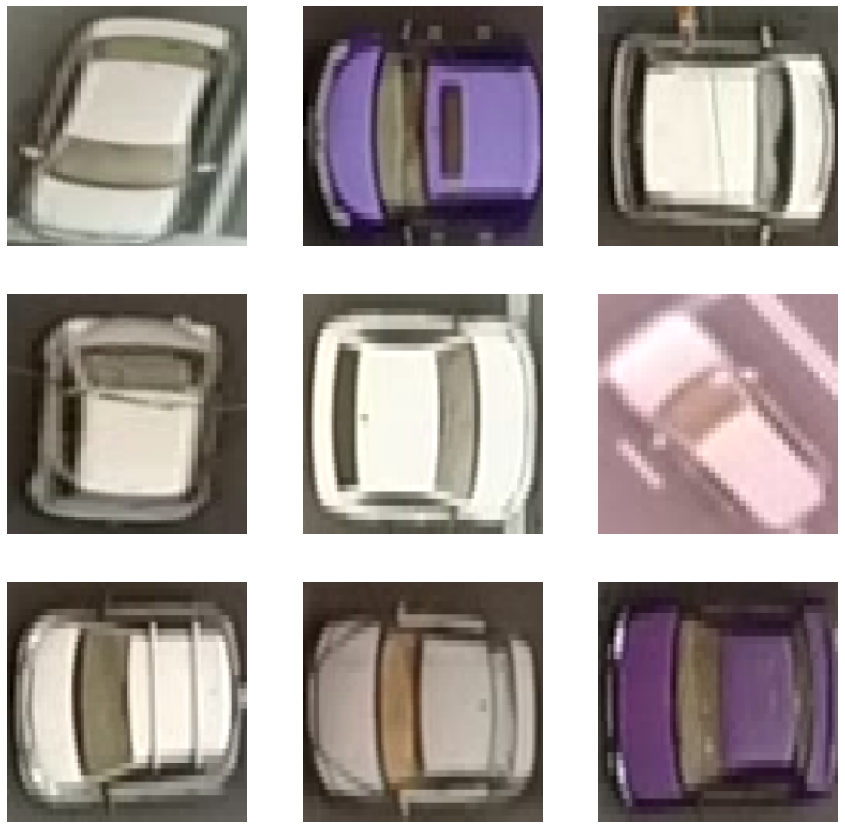

In [ ]:
plt.figure(figsize=(15, 15))

for idx , im_name in enumerate(new_sample_list):
    plt.subplot(330 + idx + 1)
    im = test_images[im_name]
    plt.axis('off')
    plt.imshow(im)
plt.show()

In [ ]:
if not os.path.exists('new_test_images.npy'):
    new_test_images  = np.array(test_images)
    new_test_labels = np.array(test_labels)
    np.save('new_test_images.npy' , tnpy)
    np.save('new_test_labels.npy' , tlnpy)
else:
    new_test_images  = np.load('new_test_images.npy')
    new_test_labels = np.load('new_test_labels.npy') 

**accuracy decreased**

In [ ]:
model.evaluate(new_test_images , new_test_labels)

3/3 [==============================] - 1s 149ms/step - loss: 13.2039 - acc: 0.0833


[13.203946113586426, 0.0833333358168602]

# **domain adaptation approach**

In [ ]:
!pip install adapt

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input

resnet50 = ResNet50(include_top=False, input_shape=(224, 224, 3), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":
        x = layer([inputs, x])
    else:
        x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_resnet50(path="resnet50_last_block.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("resnet50_last_block.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7, 7, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

In [ ]:
from sklearn.preprocessing import OneHotEncoder

Xs = first_blocks.predict(preprocess_input(np.stack(X_new[0:500])))
Xt = first_blocks.predict(preprocess_input(np.stack(new_test_images)))

one = OneHotEncoder(sparse=False)
one.fit(np.array(Y_new[0:500]).reshape(-1, 1))

ys_lab = one.transform(np.array(Y_new[0:500]).reshape(-1, 1))
yt_lab = one.transform(np.array(new_test_labels).reshape(-1, 1))

print("X source shape: %s"%str(Xs.shape))
print("X target shape: %s"%str(Xt.shape))

X source shape: (500, 7, 7, 2048)
X target shape: (96, 7, 7, 2048)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm

def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import SGD

class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta



In [ ]:
lr = 0.04
momentum = 0.9
alpha = 0.0002

optimizer_task = SGD(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum, nesterov=True)
optimizer_enc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum, nesterov=True)

**fit without adaptation**

In [ ]:
from adapt.parameter_based import FineTuning

finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=False,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(Xs[:-1], ys_lab[:-1], epochs=5, batch_size=32, validation_data=(Xt, yt_lab))

Epoch 1/5
16/16 [==============================] - 2s 50ms/step - loss: 0.7077 - acc: 0.6230 - val_loss: 2.3340 - val_acc: 0.0000e+00
Epoch 2/5
16/16 [==============================] - 0s 30ms/step - loss: 0.4237 - acc: 0.7910 - val_loss: 3.9092 - val_acc: 0.0000e+00
Epoch 3/5
16/16 [==============================] - 1s 32ms/step - loss: 0.3216 - acc: 0.8516 - val_loss: 3.3551 - val_acc: 0.1042
Epoch 4/5
16/16 [==============================] - 1s 32ms/step - loss: 0.2409 - acc: 0.8984 - val_loss: 2.3377 - val_acc: 0.1875
Epoch 5/5
16/16 [==============================] - 1s 31ms/step - loss: 0.1741 - acc: 0.9199 - val_loss: 3.0631 - val_acc: 0.2292


**fit with adaptation**

In [ ]:
np.random.seed(0)
shuffle_src = np.random.choice(len(Xs), len(Xs), replace=False)
shuffle_tgt = np.random.choice(len(Xt), len(Xt), replace=False)

Xs = Xs[shuffle_src]
ys_lab = ys_lab[shuffle_src]
Xt = Xt[shuffle_tgt]
yt_lab = yt_lab[shuffle_tgt]

In [ ]:
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

np.random.seed(123)
tf.random.set_seed(123)

lr = 0.04
momentum = 0.9
alpha = 0.0002

encoder = load_resnet50()
task = get_task()

optimizer_task = SGD(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum, nesterov=True)
optimizer_enc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum, nesterov=True)
optimizer_disc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=Xs[:-1], y=ys_lab[:-1], Xt=Xt, epochs=5, batch_size=32, validation_data=(Xt, yt_lab))

Epoch 1/5
16/16 [==============================] - 1s 57ms/step - loss: 0.1438 - acc: 0.9473 - disc_loss: 1.8186 - val_loss: 4.1619 - val_acc: 0.2188
Epoch 2/5
16/16 [==============================] - 1s 48ms/step - loss: 0.1287 - acc: 0.9492 - disc_loss: 1.8218 - val_loss: 2.1472 - val_acc: 0.4583
Epoch 3/5
16/16 [==============================] - 1s 46ms/step - loss: 0.0757 - acc: 0.9707 - disc_loss: 1.7325 - val_loss: 3.5402 - val_acc: 0.3750
Epoch 4/5
16/16 [==============================] - 1s 46ms/step - loss: 0.0724 - acc: 0.9746 - disc_loss: 1.7229 - val_loss: 2.2796 - val_acc: 0.5312
Epoch 5/5
16/16 [==============================] - 1s 48ms/step - loss: 0.0527 - acc: 0.9785 - disc_loss: 1.6705 - val_loss: 1.1616 - val_acc: 0.7708
